# A First Attempt on Simulating 2D Phi-4 Lattice

A derivation of the discretized action and Wick rotation is developed in my brown notebook. However, my result does not agree with Schaich 2006, namely because when I discretize the derivatives, I end up with a spacing of $2a$ which makes things weird with periodic boundary conditions.

### Imports

In [1]:
#imports 
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
import json
import copy
from scipy.optimize import curve_fit
import math
from scipy import fft

### Lattice algos

In [195]:
def initLattice(latticeSize: int) -> list[list[int]]:
    lattice = np.zeros((latticeSize, latticeSize))
    for i in range(latticeSize):
        for j in range(latticeSize):
            #pick a random spin
            spin = 0
            randomFloat = np.random.uniform(-2,2)
            spin = randomFloat
            #set lattice site equal to the random spin    
            lattice[i][j] = spin
    
    return lattice

In [196]:
lat = initLattice(5)
lat

array([[-1.3243618 ,  1.59456067,  1.83115901, -0.72849   ,  0.49980652],
       [-0.1830821 , -1.12076254,  0.68995985,  1.68873118,  0.19754538],
       [ 0.78279579,  1.72712483,  1.54833084, -1.7657272 , -1.38026301],
       [ 0.35344903, -1.02936009,  1.32351807, -1.23543764, -0.98749955],
       [-0.94185321, -1.80634003,  1.08627079, -1.77971279,  1.70904184]])

$S_E = \frac{1}{8} \sum_{i,j} \left( 4\phi^2(i,j) - 2\phi(i,j)\phi(i,j+2) - 2\phi(i,j)\phi(i+2,j) \right) + \sum_{i,j} \frac{1}{2} \mu_L^2 \phi^2(i,j) + \frac{\lambda_L}{4}\phi^4(i,j)$

In [933]:
# Use the Euclidean action as an energy to use for Metropolis
def deltaU(i: int, j: int, lattice: list, lamb: float, mu2: float) -> tuple[float,float]:
    '''
    After the Wick rotation, the Euclidean action fills the role of energy for Phi-4
    Here, we implement the Euclidean action as derived by myself as opposed to David's solution.

    Recall, Phi is just the value of the lattice site [-2,2). In Ising it was either -1 or 1. 
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    #I should change the periodic BC to be more robust such that i just take the mod of the lattice length

    muL2 = mu2
    lamL = lamb

    phiIJ = lattice[i][j]
    #print(lattice)
    #actionStateOne = (1/2)*np.power(phiIJ,2) - (1/4)*lattice[i][j-1]*lattice[i][j+1] - (1/4)*lattice[i-1][j]*lattice[i+1][j] + (1/2)*muL*muL*np.power(phiIJ,2) + (lamL/4)*np.power(phiIJ,4) 
    actionStateOne = (1/2)*np.power(phiIJ,2) - (1/4)*left*right - (1/4)*top*bottom + (1/2)*muL2*np.power(phiIJ,2) + (lamL/4)*np.power(phiIJ,4) 
    #YO I EDIFF FOR THE ISING MODEL I ONLY CHECK NEIGHBORING SITES??? THIS IS NOT THE CORRECT HAMILTONIAN??? THIS IS JUST A PEICE? HOW DOES THIS RELATE TO THE ACTION

    #now change the latice site and recalculate
    newLattice = copy.deepcopy(lattice)
    randomFloat = np.random.uniform(-2,2)
    newLattice[i][j] = randomFloat
    #print()
    #print(newLattice)
    #print()
    #print(lattice)
    newPhiIJ = newLattice[i][j]
    actionStateTwo = (1/2)*np.power(newPhiIJ,2) - (1/4)*left*right - (1/4)*top*bottom + (1/2)*muL2*np.power(newPhiIJ,2) + (lamL/4)*np.power(newPhiIJ,4) 

    #now calculate the energy difference
    #Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    
     #need to think about double couning and that factor of 2
    Ediff = actionStateTwo - actionStateOne #''the most negative Ediff is most negative two and most positive one'''
    #return Ediff
    #return (Ediff,newPhiIJ)
    return (Ediff,randomFloat)

$S_E = -\sum_{\langle ij \rangle} \phi_i \phi_j + \sum_n \left[ \left( 2+\frac{1}{2}\mu_0^2 \right) \phi_n^2 + \frac{\lambda}{4}\phi_n^4  \right] $

In [974]:
# Use the Euclidean action as an energy to use for Metropolis
def deltaUSCHAICH(i: int, j: int, lattice: list, lamb: float, mu2: float) -> tuple[float,float]:
    '''
    After the Wick rotation, the Euclidean action fills the role of energy for Phi-4
    Here, we implement the Euclidean action as derived by myself as opposed to David's solution.

    Recall, Phi is just the value of the lattice site [-2,2). In Ising it was either -1 or 1. 
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    muL2 = mu2
    lamL = lamb

    phiIJ = lattice[i][j]
    #print(lattice)


    #for now just drop the sums which is clearly wrong but HOW ELSE??? AHAHHSHAHAHAHHAHHA IM MISSING THE SUMM!!!!!!!
    actionStateOne = -phiIJ*(top+bottom+left+right) + (2+((muL2)/(2)))*np.power(phiIJ,2) + ((lamL)/(4))*np.power(phiIJ,4)
    

    #now change the latice site and recalculate
    newLattice = copy.deepcopy(lattice)
    randomFloat = np.random.uniform(-2,2)
    newLattice[i][j] = randomFloat
    #print()
    #print(newLattice)
    #print()
    #print(lattice)
    newPhiIJ = newLattice[i][j]
    actionStateTwo = -newPhiIJ*(top+bottom+left+right) + (2+((muL2)/(2)))*np.power(newPhiIJ,2) + ((lamL)/(4))*np.power(newPhiIJ,4) 

    #now calculate the energy difference
    #Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    
     #need to think about double couning and that factor of 2
    Ediff = actionStateTwo - actionStateOne #''the most negative Ediff is most negative two and most positive one'''
    #return Ediff
    #return (Ediff,newPhiIJ)
    return (Ediff,randomFloat)

In [350]:
#net zero is symmetric phase

In [733]:
lat = initLattice(5) #5: -403.95950916467325 (404 is prob the number?) 10: same? 20:
minEd = 0
for i in range(100000):
    curEd = deltaU(2,2,lat)
    if curEd < minEd:
        minEd = curEd
    lat = initLattice(5)

print(minEd)

KeyboardInterrupt: 

In [666]:
lat = initLattice(5)
res = deltaU(2,2,lat)
while res >= 0:
    lat = initLattice(5)
    res = deltaU(2,2,lat)

print(lat)
print(res)
print(np.exp(-res))

[[-1.97527814 -1.0846589   0.78776906  1.75745415  1.8930952 ]
 [ 1.65800715 -0.70825064  0.89656892  0.87925794 -0.68991455]
 [-1.75808955 -1.69833184  0.32344407 -1.44032367 -0.07809837]
 [-1.40934192  0.88509748 -1.16074081  1.33343083  0.13116275]
 [-1.46220328  1.78966746  0.03264618 -0.95736373 -0.58958585]]

[[-1.97527814 -1.0846589   0.78776906  1.75745415  1.8930952 ]
 [ 1.65800715 -0.70825064  0.89656892  0.87925794 -0.68991455]
 [-1.75808955 -1.69833184 -0.24418014 -1.44032367 -0.07809837]
 [-1.40934192  0.88509748 -1.16074081  1.33343083  0.13116275]
 [-1.46220328  1.78966746  0.03264618 -0.95736373 -0.58958585]]

[[-1.97527814 -1.0846589   0.78776906  1.75745415  1.8930952 ]
 [ 1.65800715 -0.70825064  0.89656892  0.87925794 -0.68991455]
 [-1.75808955 -1.69833184  0.32344407 -1.44032367 -0.07809837]
 [-1.40934192  0.88509748 -1.16074081  1.33343083  0.13116275]
 [-1.46220328  1.78966746  0.03264618 -0.95736373 -0.58958585]]
[[-1.97527814 -1.0846589   0.78776906  1.75745415 

In [778]:
lat = initLattice(5)
print(lat)
deltaU(2,2,lat)
print(lat[2][2])

[[-1.80834615 -1.27419834  1.63128664  1.83368327 -1.96659812]
 [-0.31347942 -0.85963377 -0.67636316 -1.3790941   0.33844964]
 [-0.53967207  0.21550061 -1.85492347 -0.31610414 -1.89531824]
 [-1.9947254   1.71552365  0.28839884 -1.45579478 -0.82746035]
 [-1.99841426 -1.77042505 -0.3143757  -0.13784391  1.38685506]]
-1.8549234730483666


In [934]:
def Metropolis(lattice, iterations, lamb , mu2):
    for iteration in range(iterations):
        i = random.randint(0,len(lattice[0])-1)
        j = random.randint(0,len(lattice[0])-1)
        #print(i,j)
        deltaUResult = deltaU(i,j,lattice,lamb, mu2)
        Ediff = deltaUResult[0]
        newSpin = deltaUResult[1]
        #Metropolis to decide whether site should be flipped.
        if(Ediff <= 0):
            lattice[i][j] = newSpin
            #print("FLIPPED")
        else:
            #now only flip site according to Boltzmann factor IS THIS STILL THE CORRECT WEIGHTING????
            '''The Boltzmann factor gives the probability of flipping the site if Ediff > 0. 
                However, e^-U/kT becamse e^-S which is strictly positive. But now S can be <0 such that e^-S > 1. Need to think of a way to normalize this to [0,1]
                Divide by max value in image of e^-S? (when S is minimized) Skews other probs down? Is the minimum action the vacuum state? Proof?'''
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff)): #WRONG:(Ediff must be positive so exponential is between 0 and 1) # get rid of temperature (just action)
                lattice[i][j] = newSpin
                #print("ELSE FLIP")

In [975]:
def MetropolisSCHAICH(lattice, iterations, lamb , mu2):
    for iteration in range(iterations):
        i = random.randint(0,len(lattice[0])-1)
        j = random.randint(0,len(lattice[0])-1)
        #print(i,j)
        deltaUResult = deltaUSCHAICH(i,j,lattice,lamb, mu2)
        Ediff = deltaUResult[0]
        newSpin = deltaUResult[1]
        #Metropolis to decide whether site should be flipped.
        if(Ediff <= 0):
            lattice[i][j] = newSpin
            #print("FLIPPED")
        else:
            #now only flip site according to Boltzmann factor IS THIS STILL THE CORRECT WEIGHTING????
            '''The Boltzmann factor gives the probability of flipping the site if Ediff > 0. 
                However, e^-U/kT becamse e^-S which is strictly positive. But now S can be <0 such that e^-S > 1. Need to think of a way to normalize this to [0,1]
                Divide by max value in image of e^-S? (when S is minimized) Skews other probs down? Is the minimum action the vacuum state? Proof?'''
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff)): #WRONG:(Ediff must be positive so exponential is between 0 and 1) # get rid of temperature (just action)
                lattice[i][j] = newSpin
                #print("ELSE FLIP")

might make sense to try this same thing on the Ising code

In [884]:
lat = initLattice(5)
print(lat)
Metropolis(lat,1)
print()
print(lat)

[[ 1.15184219  1.85548915 -1.33876651  1.3860548  -0.75329666]
 [ 1.99266029  1.85133329 -1.34786711  1.83733024 -1.06346774]
 [ 1.77648434 -1.95083604  0.34856971 -0.0436253   0.61454448]
 [-0.81413107  1.91782895 -0.94048878 -1.49177371 -1.52762357]
 [-0.97375053  0.2476349   1.84555389 -0.23338358 -0.42423528]]
2 3
ELSE FLIP

[[ 1.15184219  1.85548915 -1.33876651  1.3860548  -0.75329666]
 [ 1.99266029  1.85133329 -1.34786711  1.83733024 -1.06346774]
 [ 1.77648434 -1.95083604  0.34856971  0.15867883  0.61454448]
 [-0.81413107  1.91782895 -0.94048878 -1.49177371 -1.52762357]
 [-0.97375053  0.2476349   1.84555389 -0.23338358 -0.42423528]]


Before the "temperature" was a factor weigting the Metropolis update. Now, it is a parameter in the energy effecting the deltaU update.

In [754]:
#lattice starts in symmetric phase (random float is picked for a float)
size = 10
lat = initLattice(size)

iters = 100
for i in range(iters):
    sum = 0
    for i in range(size):
        for j in range(size):
            sum += lat[i][j]
    print(sum/(size*size))

    #update lattice with metropolis
    Metropolis(lat,10000) #ADD A PARAMETER FOR LAMBDA INTO METROPOLIS AND FEED IT INTO DELTAU!!!!!!

-0.22380322151823395
0.04097919051677551
0.0034131612958563907
0.03659363764459081
-0.02154019640188451
-0.008427471112362599
-0.04161598608459049
0.021467102503712178
0.01110495966831853
-0.03627889748162286
0.05558775642596967
-0.014144469627130993
0.017477288241421928
-0.006899719111675738
0.008965779429749951
0.034695350365783924
-0.015147105099560831
-0.05064111565373649
0.0344701759900601
0.027005086085416137
0.009472225035848183
-0.03205593873484882
-0.017627906143430464
0.01874550884999918
0.034055640357775224
-0.03256889460473894
-0.025738145057890658
-0.00014111153746463768
-0.00018682181892529126
-0.02109793387671596
0.010167212635128133
0.007087547289528171
-0.052290770209943764
-0.012813858748206166
0.01305899627173162
0.02198777181500585
0.006085024392862963
-0.005239640967984185
-0.024284590888579413
0.05989868721372424
-0.01939908391222277
-0.015108345999636659
0.03218680350426716
0.00422095437232155
0.009515061234827576
0.028426129584204637
0.0004296910498019324
-0.013

In [935]:
#removed temp
def calcMagArr(lattice,iterations, lamb , mu2):
    mArr = []
    for iteration in range(iterations):
        Metropolis(lattice, iterations,lamb,mu2)
        if(iteration % 10 ==  0): #was 99, but could make this sooner if autocor allows for it. (think about wolff? ahhhh)
            sum = 0
            for xSite in range(len(lattice[0])):
                for ySite in range(len(lattice[0])):
                    sum += lattice[xSite][ySite]
            mArr.append(abs(sum)) 
    
    return mArr

In [976]:
#removed temp
def calcMagArrSCHAICH(lattice,iterations, lamb , mu2):
    mArr = []
    for iteration in range(iterations):
        MetropolisSCHAICH(lattice, iterations,lamb,mu2)
        if(iteration % 10 ==  0): #was 99, but could make this sooner if autocor allows for it. (think about wolff? ahhhh)
            sum = 0
            for xSite in range(len(lattice[0])):
                for ySite in range(len(lattice[0])):
                    sum += lattice[xSite][ySite]
            mArr.append(abs(sum)) 
    
    return mArr

In [958]:
lat = initLattice(20)
avgArr = []
lam = 1
muRange = np.arange(-50,20)
for mu in muRange:
    mArr = calcMagArr(lat,1000, lam, mu)
    avgArr.append(np.average(mArr))

avgArr

[36.08228707904815,
 28.06832384768776,
 38.65529092314673,
 27.64404099485065,
 44.053206676984054,
 27.459868671023226,
 41.52719219338922,
 40.5810846862447,
 36.16189086997071,
 29.969224910240033,
 36.71400462594524,
 33.23387200808077,
 35.64370256924853,
 35.11544450128085,
 33.94461591428578,
 29.528645782145578,
 32.472125434214355,
 30.48627642208533,
 30.909939273820637,
 28.968594847152282,
 35.57528649979465,
 33.28829264825145,
 32.745602623629935,
 32.011860613714816,
 35.370024717406515,
 25.955046053537917,
 30.123704204002323,
 35.22433380834508,
 34.16013671000476,
 30.944108959765007,
 33.33447141412957,
 31.06755956041606,
 32.031653774406045,
 32.486904724305916,
 30.1427672208346,
 28.320524997027693,
 29.305967733716592,
 32.39552376420061,
 32.45223762375053,
 33.19321454601115,
 28.132007571350062,
 30.256743650911552,
 29.227894764343898,
 31.132229007249524,
 23.91967167103592,
 24.244341260598357,
 22.223041897385407,
 18.77702190453963,
 14.506760962432727

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/var/folders/tf/m_q5jhc978j5bnsvc9p4163h0000gn/T/ipykernel_28130/1014262249.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu^2$ with $\lambda=1$")


Text(0, 0.5, '$m$')

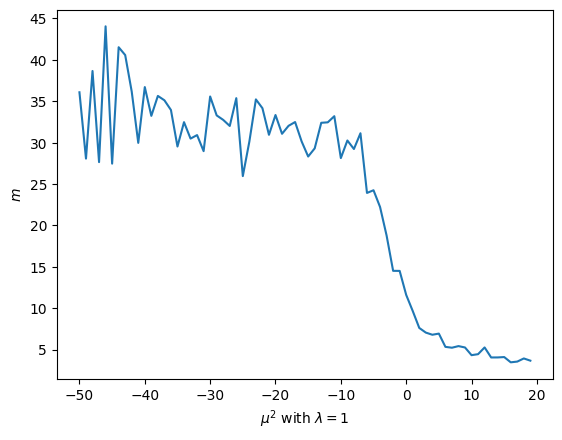

In [959]:
plt.plot(muRange, avgArr)
plt.xlabel("$\mu^2$ with $\lambda=1$")
plt.ylabel("$m$")

!!! This seems like strong evidence of a phase transition! I should overplot david schaich's method and see how they differ.

In [988]:
'''THE DAVID SCHAICH METHOD'''
lat = initLattice(20)
SchaichAvgArr7 = []
lam = 0.5
muRange = np.arange(-50,20)
for mu in muRange:
    SchaichmArr = calcMagArrSCHAICH(lat,1000, lam, mu)
    SchaichAvgArr7.append(np.average(SchaichmArr))

SchaichAvgArr7

In [986]:
SchaichAvgArr=[302.7153632414202,
 633.3774102061523,
 795.3663315782791,
 795.2664812956018,
 795.3789890619728,
 794.8613702426393,
 795.1905383108405,
 794.9568854659047,
 794.62485429555,
 794.4974711508477,
 794.5573733700554,
 794.4581654270623,
 794.1757926332405,
 793.8209888981532,
 793.645135344345,
 793.4758083564984,
 793.1499486265573,
 793.1648677619149,
 792.7748135103072,
 792.6384437057106,
 792.282322181448,
 792.0368694214551,
 791.5025541308707,
 791.0886757969015,
 791.0501027672267,
 790.3055941803805,
 789.653823654387,
 789.2993846200085,
 788.6348832570787,
 787.9564233843668,
 787.2218667497779,
 786.6105805771781,
 785.6802725271849,
 784.3658902532767,
 783.1982805795742,
 781.4993190219753,
 779.9280447195983,
 777.7870741427346,
 775.5723106253631,
 772.2296488424498,
 767.9456027327853,
 762.5380654117705,
 755.0500557950024,
 744.3710120963132,
 729.24010963036,
 706.659436109621,
 668.6737119775405,
 602.4452719467673,
 475.9925534598773,
 66.27099825372645,
 17.724980120250684,
 13.69676944724165,
 11.501639327346338,
 7.456031254053939,
 7.9227197225198145,
 6.728361378478013,
 5.9057351088764305,
 5.0936637743166076,
 4.782129046219123,
 5.3152969110690105,
 5.702839669043471,
 4.6113141051712,
 3.914360347794874,
 3.789422866369331,
 4.163592665600832,
 3.78168920140927,
 4.034365116615603,
 3.777804323175727,
 3.4953052445624366,
 3.399076436100533]

TODO: CONTINUE THIS SERIES. THEN FIGURE OUT SUS. THEN RESOLVE ME AND SCHAICH DIFFERENCES

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
/var/folders/tf/m_q5jhc978j5bnsvc9p4163h0000gn/T/ipykernel_28130/940979400.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu^2$ with $\lambda=1$")


(-20.0, 10.0)

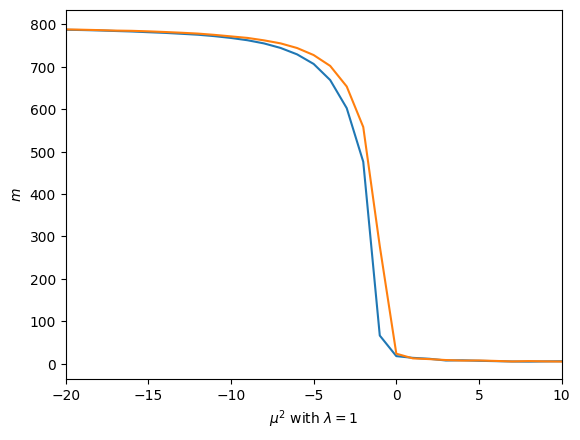

In [987]:
plt.plot(muRange, SchaichAvgArr)
plt.plot(muRange, SchaichAvgArr7)
plt.xlabel("$\mu^2$ with $\lambda=1$")
plt.ylabel("$m$")
plt.xlim(-20,10)

Funny plot of trying to recreate Ising model results. Clearly its meaningless (??) Maybe it should thermalize to somwhere at low temperatures?? At any rate it doesnt really matter since we are plotting neither the OP nor the CP.

I need to find out how to calc vacuum expectation value and vary the critical coupling $\frac{\lambda}{\mu^2}$

OP: just like mag -- a sum of all lattice sites (normalized by number of sites if you want to) \
CP: 2d space -- fix one and sweep. this will make a curve

Schaich, Loinaz, Willey seem to not generate this plot? One transition indicator used is susceptibility. THIS IS A ROUGH LATE NIGHT ATTEMPT. I need to look into what suscep. looks like if no temp exists?

In [965]:
#Susceptibility function
def calcSus(lattice, lamb, mu2):
    m2Arr = []
    magArr = calcMagArr(lattice, 1000, lamb, mu2) #already doing 10k iterations on the mag . . . and 10 on the BC call in plotting 1000000
    m2Arr = [np.power(x,2) for x in magArr]
    
    avgm = np.average(magArr)
    avgm2 = np.average(m2Arr)

    sus = (avgm2 - np.power(avgm,2))
      

    return sus


In [972]:
lat = initLattice(20)
avgSusArr = []
lam = 1
muRange = np.linspace(-50,5,30)
for mu in muRange:
    mArr = calcSus(lat, lam, mu)
    avgSusArr.append(np.average(mArr))

avgSusArr

[535.8794940613227,
 629.6961534747486,
 559.6520397591077,
 405.2026908195387,
 531.2507711823249,
 436.2212460584833,
 507.79387353865764,
 672.8836137342034,
 898.8677587967993,
 728.8975818611789,
 627.8975038672902,
 556.7090194011041,
 436.37699251749154,
 371.99448177494196,
 466.5760602882193,
 796.6625467509214,
 572.919091169246,
 465.9644941018904,
 365.7725071748605,
 326.56748490963855,
 456.31799652071925,
 593.6841693110589,
 395.4128038165694,
 564.6917195219287,
 413.1166599656739,
 131.18354515351086,
 86.38962181132135,
 49.36675897385426,
 27.49171112202614,
 22.372889652178145]

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\c'
/var/folders/tf/m_q5jhc978j5bnsvc9p4163h0000gn/T/ipykernel_28130/1898682862.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel("$\mu^2$ with $\lambda=1$")
/var/folders/tf/m_q5jhc978j5bnsvc9p4163h0000gn/T/ipykernel_28130/1898682862.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel("$\chi$")


Text(0, 0.5, '$\\chi$')

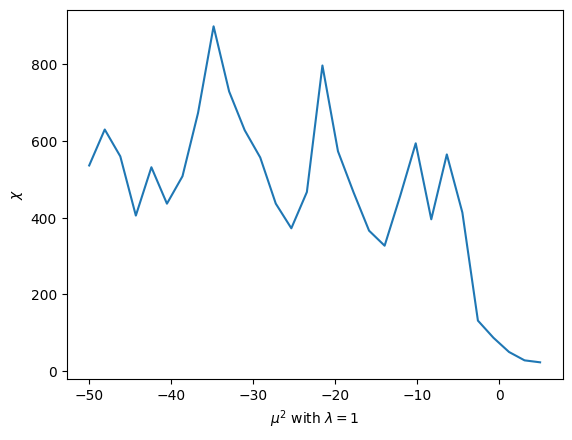

In [973]:
plt.plot(muRange, avgSusArr)
plt.xlabel("$\mu^2$ with $\lambda=1$")
plt.ylabel("$\chi$")

In [ ]:
plt.plot(muRange, avgSusArr)

In [ ]:
size = 10
lattice = initLattice(size)

tempRange = np.flip(np.arange(0.1,4,0.01))
susArr = []
for temp in tempRange:
    percent = round((tempRange[0]-temp)/tempRange[0] * 100,1)
    print("%s%%    L=%s" % (percent,size))
    sus = calcSus(lattice, temp)
    susArr.append(sus)

name = "sus%sArrNEW.txt" % str(size)
with open(name, 'w') as filehandle:
    json.dump(susArr, filehandle)